In [3]:
import os
import sys

conda_env = r"C:\Users\subha\anaconda3\envs\XGboost"

os.environ["GDAL_DATA"] = os.path.join(conda_env, "Library", "share", "gdal")
os.environ["PROJ_LIB"] = os.path.join(conda_env, "Library", "share", "proj")

print("GDAL_DATA:", os.environ["GDAL_DATA"])
print("PROJ_LIB:", os.environ["PROJ_LIB"])


GDAL_DATA: C:\Users\subha\anaconda3\envs\XGboost\Library\share\gdal
PROJ_LIB: C:\Users\subha\anaconda3\envs\XGboost\Library\share\proj


CRS match confirmed.
Intersection check: Yes


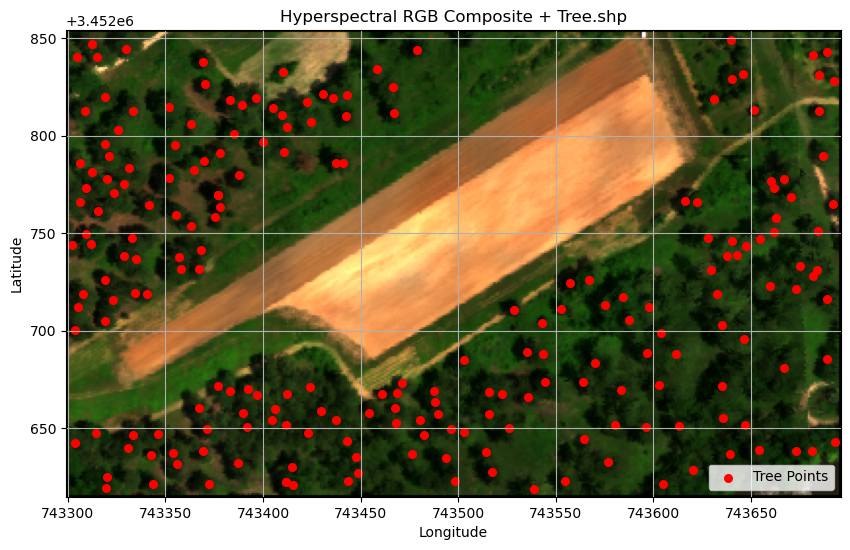

In [5]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np

raster_path = r"E:\Hyperspectral\TreeExtraction\Data\NEON_HSI_2014_JERC.tif"
shapefile_path = r"E:\Hyperspectral\TreeExtraction\Data\Tree.shp"

RED_BAND = 53
GREEN_BAND = 35
BLUE_BAND = 19

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    raster_bounds = src.bounds
    raster_extent = box(*raster_bounds)
    
    red = src.read(RED_BAND).astype(np.float32)
    green = src.read(GREEN_BAND).astype(np.float32)
    blue = src.read(BLUE_BAND).astype(np.float32)
    transform = src.transform
    
nodata_mask = ((red == -9999) | (green == -9999) | (blue == -9999) |
               (red == 0) | (green == 0) | (blue == 0))

red[nodata_mask] = np.nan
green[nodata_mask] = np.nan
blue[nodata_mask] = np.nan

rgb = np.stack([red, green, blue], axis=-1)
valid_pixels = ~np.isnan(rgb).any(axis=-1)

rgb_min, rgb_max = np.percentile(rgb[valid_pixels], (2, 98))
rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-6)
rgb = np.clip(rgb, 0, 1)

rgb[~valid_pixels] = np.nan

gdf = gpd.read_file(shapefile_path)
shapefile_crs = gdf.crs

if shapefile_crs != raster_crs:
    print("CRS mismatch. Reprojecting shapefile...")
    gdf = gdf.to_crs(raster_crs)
else:
    print("CRS match confirmed.")

raster_geom = gpd.GeoDataFrame(geometry=[raster_extent], crs=raster_crs)
intersects = gdf.intersects(raster_extent).any()
print("Intersection check:", "Yes" if intersects else "No")

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(rgb, extent=[raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top])
gdf.plot(ax=ax, color='red', markersize=30, label='Tree Points')

plt.legend()
plt.title("Hyperspectral RGB Composite + Tree.shp")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [7]:
import rasterio
import numpy as np

input_path = r"E:\Hyperspectral\TreeExtraction\Data\NEON_HSI_2014_JERC.tif"
output_path = r"E:\Hyperspectral\TreeExtraction\Data\Image_Scaled.tif"
NODATA_VALUES = [-9999, 0] 

with rasterio.open(input_path) as src:
    profile = src.profile
    data = src.read().astype(np.float32)

nodata_mask = np.isin(data, NODATA_VALUES)

data = np.where(nodata_mask, np.nan, data)

scaled_data = np.empty_like(data, dtype=np.float32)
for b in range(data.shape[0]):
    band = data[b]
    band_min = np.nanmin(band)
    band_max = np.nanmax(band)

    if band_max > band_min:
        scaled_band = (band - band_min) / (band_max - band_min)
    else:
        scaled_band = np.zeros_like(band)
    
    scaled_band[np.isnan(band)] = np.nan
    scaled_data[b] = scaled_band

profile.update(dtype=rasterio.float32, nodata=np.nan)

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(scaled_data.astype(np.float32))

print("✅ Scaled image saved to:", output_path)


✅ Scaled image saved to: E:\Hyperspectral\TreeExtraction\Data\Image_Scaled.tif


Top 50 bands based on Tree pixels: [np.int64(426), np.int64(422), np.int64(425), np.int64(138), np.int64(137), np.int64(139), np.int64(136), np.int64(135), np.int64(140), np.int64(134), np.int64(133), np.int64(132), np.int64(142), np.int64(141), np.int64(131), np.int64(130), np.int64(129), np.int64(143), np.int64(128), np.int64(98), np.int64(127), np.int64(101), np.int64(100), np.int64(96), np.int64(99), np.int64(126), np.int64(102), np.int64(97), np.int64(145), np.int64(105), np.int64(93), np.int64(95), np.int64(94), np.int64(144), np.int64(125), np.int64(92), np.int64(124), np.int64(150), np.int64(108), np.int64(112), np.int64(91), np.int64(123), np.int64(89), np.int64(104), np.int64(106), np.int64(107), np.int64(90), np.int64(122), np.int64(103), np.int64(146)]
✅ Composite full image saved: E:\Hyperspectral\TreeExtraction\Data\TreeTop50Bands\TopBands_50_Full.tif


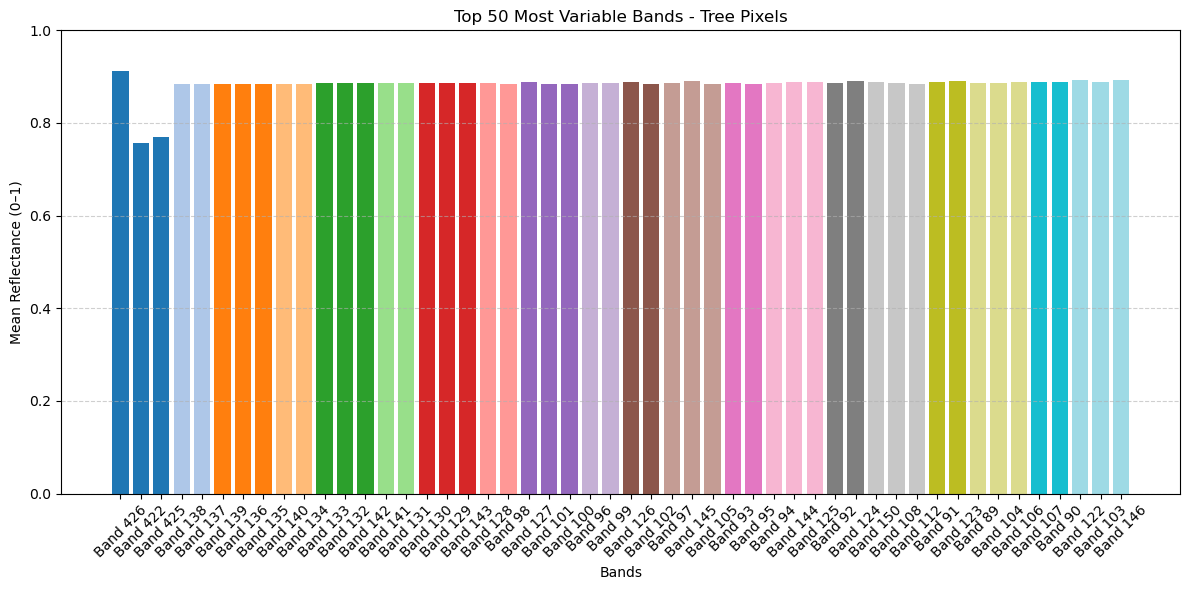

In [13]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os

image_path = r"E:\Hyperspectral\TreeExtraction\Data\Image_Scaled.tif"
mask_path = r"E:\Hyperspectral\TreeExtraction\Data\Tree.shp"
output_dir = r"E:\Hyperspectral\TreeExtraction\Data\TreeTop50Bands"
Top_Band = 50 

os.makedirs(output_dir, exist_ok=True)

gdf = gpd.read_file(mask_path)

with rasterio.open(image_path) as src:
    full_data = src.read().astype(np.float32)
    profile = src.profile
    
with rasterio.open(image_path) as src:
    tree_masked, _ = mask(src, gdf.geometry, crop=True)
    tree_masked = tree_masked.astype(np.float32)
    
if profile.get("nodata") is not None:
    tree_masked[tree_masked == profile["nodata"]] = np.nan

band_variances = np.nanvar(tree_masked.reshape(tree_masked.shape[0], -1), axis=1)

top_indices = np.argsort(band_variances)[-Top_Band:]
top_indices = top_indices[np.argsort(band_variances[top_indices])[::-1]]  # descending
top_band_numbers = top_indices + 1
print(f"Top {Top_Band} bands based on Tree pixels: {list(top_band_numbers)}")

profile.update(count=len(top_indices), dtype=rasterio.float32, compress="lzw")
composite_path = os.path.join(output_dir, f"TopBands_{Top_Band}_Full.tif")

with rasterio.open(composite_path, "w", **profile) as dst:
    for i, band_idx in enumerate(top_indices):
        dst.write(full_data[band_idx, :, :], i + 1)

print(f"✅ Composite full image saved: {composite_path}")

mean_reflectance = np.nanmean(tree_masked.reshape(tree_masked.shape[0], -1), axis=1)
top_mean_reflectance = mean_reflectance[top_indices]

plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, Top_Band))
plt.bar(range(Top_Band), top_mean_reflectance, color=colors)
plt.xticks(range(Top_Band), [f"Band {i}" for i in top_band_numbers], rotation=45)
plt.ylabel("Mean Reflectance (0–1)")
plt.xlabel("Bands")
plt.title(f"Top {Top_Band} Most Variable Bands - Tree Pixels")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Top 50 bands based on Tree pixels: [np.int64(426), np.int64(425), np.int64(422), np.int64(423), np.int64(424), np.int64(138), np.int64(139), np.int64(137), np.int64(140), np.int64(142), np.int64(136), np.int64(141), np.int64(178), np.int64(135), np.int64(179), np.int64(143), np.int64(134), np.int64(181), np.int64(133), np.int64(145), np.int64(180), np.int64(182), np.int64(132), np.int64(144), np.int64(183), np.int64(185), np.int64(184), np.int64(175), np.int64(174), np.int64(131), np.int64(130), np.int64(176), np.int64(177), np.int64(173), np.int64(129), np.int64(146), np.int64(172), np.int64(171), np.int64(150), np.int64(128), np.int64(187), np.int64(186), np.int64(127), np.int64(170), np.int64(317), np.int64(126), np.int64(169), np.int64(219), np.int64(191), np.int64(189)]
✅ Composite full image saved: E:\Hyperspectral\TreeExtraction\Data\NonTreeTop50Bands\TopBands_50_Full.tif


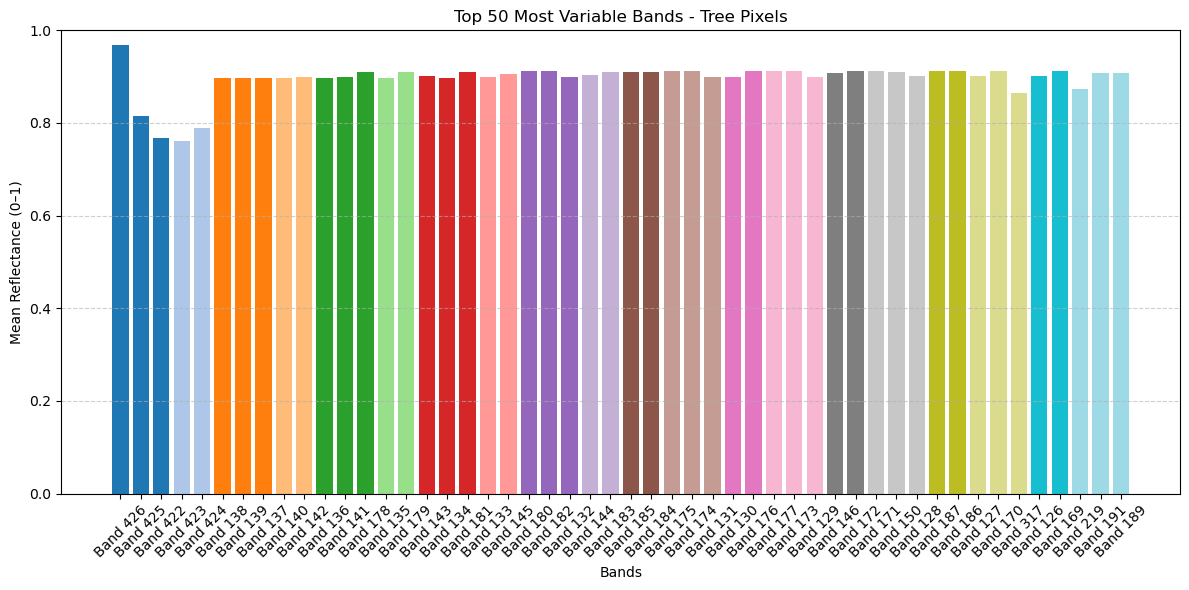

In [15]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os

image_path = r"E:\Hyperspectral\TreeExtraction\Data\Image_Scaled.tif"
mask_path = r"E:\Hyperspectral\TreeExtraction\Data\Non_Tree.shp"
output_dir = r"E:\Hyperspectral\TreeExtraction\Data\NonTreeTop50Bands"
Top_Band = 50

os.makedirs(output_dir, exist_ok=True)

gdf = gpd.read_file(mask_path)

with rasterio.open(image_path) as src:
    full_data = src.read().astype(np.float32)
    profile = src.profile

with rasterio.open(image_path) as src:
    tree_masked, _ = mask(src, gdf.geometry, crop=True)
    tree_masked = tree_masked.astype(np.float32)
    
if profile.get("nodata") is not None:
    tree_masked[tree_masked == profile["nodata"]] = np.nan

band_variances = np.nanvar(tree_masked.reshape(tree_masked.shape[0], -1), axis=1)

top_indices = np.argsort(band_variances)[-Top_Band:]
top_indices = top_indices[np.argsort(band_variances[top_indices])[::-1]]  
top_band_numbers = top_indices + 1
print(f"Top {Top_Band} bands based on Tree pixels: {list(top_band_numbers)}")

profile.update(count=len(top_indices), dtype=rasterio.float32, compress="lzw")
composite_path = os.path.join(output_dir, f"TopBands_{Top_Band}_Full.tif")

with rasterio.open(composite_path, "w", **profile) as dst:
    for i, band_idx in enumerate(top_indices):
        dst.write(full_data[band_idx, :, :], i + 1)

print(f"✅ Composite full image saved: {composite_path}")

mean_reflectance = np.nanmean(tree_masked.reshape(tree_masked.shape[0], -1), axis=1)
top_mean_reflectance = mean_reflectance[top_indices]

plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, Top_Band))
plt.bar(range(Top_Band), top_mean_reflectance, color=colors)
plt.xticks(range(Top_Band), [f"Band {i}" for i in top_band_numbers], rotation=45)
plt.ylabel("Mean Reflectance (0–1)")
plt.xlabel("Bands")
plt.title(f"Top {Top_Band} Most Variable Bands - Tree Pixels")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [17]:
list1 = [426, 422, 425, 138, 137, 139, 136, 135, 140, 134, 
 133, 132, 142, 141, 131, 130, 129, 143, 128, 98, 
 127, 101, 100, 96, 99, 126, 102, 97, 145, 105, 
 93, 95, 94, 144, 125, 92, 124, 150, 108, 112, 
 91, 123, 89, 104, 106, 107, 90, 122, 103, 146]

list2 = [426, 425, 422, 423, 424, 138, 139, 137, 140, 142, 
 136, 141, 178, 135, 179, 143, 134, 181, 133, 145, 
 180, 182, 132, 144, 183, 185, 184, 175, 174, 131, 
 130, 176, 177, 173, 129, 146, 172, 171, 150, 128, 
 187, 186, 127, 170, 317, 126, 169, 219, 191, 189]

common_bands = list(set(list1) & set(list2))
print("✅ Common bands (appear in both lists):", common_bands)

unique_list1 = list(set(list1) - set(list2))
unique_list2 = list(set(list2) - set(list1))

print("\n⚡ Unique bands in List1 only:", unique_list1)
print("⚡ Unique bands in List2 only:", unique_list2)

common_bands.sort()
unique_list1.sort()
unique_list2.sort()

print("\n--- Sorted Result ---")
print("Common bands:", common_bands)
print("Unique in List1:", unique_list1)
print("Unique in List2:", unique_list2)


✅ Common bands (appear in both lists): [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 150, 422, 425, 426, 126, 127]

⚡ Unique bands in List1 only: [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 112, 122, 123, 124, 125]
⚡ Unique bands in List2 only: [423, 424, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 317, 189, 191, 219]

--- Sorted Result ---
Common bands: [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 150, 422, 425, 426]
Unique in List1: [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 112, 122, 123, 124, 125]
Unique in List2: [169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 191, 219, 317, 423, 424]


In [23]:
import rasterio
import numpy as np
import os

tree_tif = r"E:\Hyperspectral\TreeExtraction\Data\TreeTop50Bands\TopBands_50_Full.tif"
non_tree_tif = r"E:\Hyperspectral\TreeExtraction\Data\NonTreeTop50Bands\TopBands_50_Full.tif"
output_dir = r"E:\Hyperspectral\TreeExtraction\Data\MosaicTopBands"
os.makedirs(output_dir, exist_ok=True)
mosaic_tif = os.path.join(output_dir, "Mosaic_Top_Unique_Bands.tif")

tree_bands = [426, 422, 425, 138, 137, 139, 136, 135, 140, 134, 
 133, 132, 142, 141, 131, 130, 129, 143, 128, 98, 
 127, 101, 100, 96, 99, 126, 102, 97, 145, 105, 
 93, 95, 94, 144, 125, 92, 124, 150, 108, 112, 
 91, 123, 89, 104, 106, 107, 90, 122, 103, 146]
non_tree_bands = [426, 425, 422, 423, 424, 138, 139, 137, 140, 142, 
 136, 141, 178, 135, 179, 143, 134, 181, 133, 145, 
 180, 182, 132, 144, 183, 185, 184, 175, 174, 131, 
 130, 176, 177, 173, 129, 146, 172, 171, 150, 128, 
 187, 186, 127, 170, 317, 126, 169, 219, 191, 189]

unique_bands = sorted(list(set(tree_bands) ^ set(non_tree_bands)))  # symmetric difference
print(f"✅ Unique bands across Tree & Non-Tree: {unique_bands}")

tree_idx = [tree_bands.index(b) for b in unique_bands if b in tree_bands]
non_tree_idx = [non_tree_bands.index(b) for b in unique_bands if b in non_tree_bands]

with rasterio.open(tree_tif) as src1:
    tree_data = src1.read().astype(np.float32)
    profile = src1.profile

with rasterio.open(non_tree_tif) as src2:
    non_tree_data = src2.read().astype(np.float32)

tree_unique_data = tree_data[tree_idx, :, :] if tree_idx else np.empty((0, *tree_data.shape[1:]))
non_tree_unique_data = non_tree_data[non_tree_idx, :, :] if non_tree_idx else np.empty((0, *non_tree_data.shape[1:]))

mosaic_unique_data = np.vstack([tree_unique_data, non_tree_unique_data])

profile.update(count=mosaic_unique_data.shape[0], dtype=rasterio.float32, compress="lzw")

with rasterio.open(mosaic_tif, "w", **profile) as dst:
    for i in range(mosaic_unique_data.shape[0]):
        dst.write(mosaic_unique_data[i, :, :], i + 1)

print(f"✅ Mosaic of unique bands saved: {mosaic_tif}")
print(f"Shape of unique mosaic: {mosaic_unique_data.shape} (bands, height, width)")


✅ Unique bands across Tree & Non-Tree: [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 112, 122, 123, 124, 125, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 191, 219, 317, 423, 424]
✅ Mosaic of unique bands saved: E:\Hyperspectral\TreeExtraction\Data\MosaicTopBands\Mosaic_Top_Unique_Bands.tif
Shape of unique mosaic: (50, 239, 397) (bands, height, width)


In [25]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd

image_path = r"E:\Hyperspectral\TreeExtraction\Data\MosaicTopBands\Mosaic_Top_Unique_Bands.tif"
mask_path = r"E:\Hyperspectral\TreeExtraction\Data\Tree.shp"
csv_output_path = r"E:\Hyperspectral\TreeExtraction\Data\Tree_Pixels_Reflectance.csv"

gdf = gpd.read_file(mask_path)

with rasterio.open(image_path) as src:
    # Reproject mask to image CRS
    gdf = gdf.to_crs(src.crs)

    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    profile = src.profile

    bands, height, width = out_image.shape

    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs, ys = rasterio.transform.xy(out_transform, rows, cols)
    xs = np.array(xs).flatten()
    ys = np.array(ys).flatten()

    all_bands = out_image.reshape(bands, -1).T  # shape -> (num_pixels, bands)

    if profile.get("nodata") is not None:
        nodata_mask = np.any(all_bands == profile["nodata"], axis=1)
        all_bands[nodata_mask] = np.nan

band_columns = [f"Band{i+1}" for i in range(bands)]
df = pd.DataFrame(all_bands, columns=band_columns)
df["Longitude"] = xs
df["Latitude"] = ys
df["Class"] = 1
df["Class_Name"] = "Tree"

df = df.dropna()

# Save to CSV
df.to_csv(csv_output_path, index=False)
print(f"✅ Tree pixels reflectance saved to {csv_output_path}")


✅ Tree pixels reflectance saved to E:\Hyperspectral\TreeExtraction\Data\Tree_Pixels_Reflectance.csv


In [27]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import pandas as pd

image_path = r"E:\Hyperspectral\TreeExtraction\Data\MosaicTopBands\Mosaic_Top_Unique_Bands.tif"
mask_path = r"E:\Hyperspectral\TreeExtraction\Data\Non_Tree.shp"
csv_output_path = r"E:\Hyperspectral\TreeExtraction\Data\Non_Tree_Pixels_Reflectance.csv"

gdf = gpd.read_file(mask_path)

with rasterio.open(image_path) as src:
    gdf = gdf.to_crs(src.crs)
    
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    profile = src.profile

    bands, height, width = out_image.shape
    
    rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    xs, ys = rasterio.transform.xy(out_transform, rows, cols)
    xs = np.array(xs).flatten()
    ys = np.array(ys).flatten()

    all_bands = out_image.reshape(bands, -1).T  # shape -> (num_pixels, bands)

    if profile.get("nodata") is not None:
        nodata_mask = np.any(all_bands == profile["nodata"], axis=1)
        all_bands[nodata_mask] = np.nan

band_columns = [f"Band{i+1}" for i in range(bands)]
df = pd.DataFrame(all_bands, columns=band_columns)
df["Longitude"] = xs
df["Latitude"] = ys
df["Class"] = 2
df["Class_Name"] = "Non_Tree"

df = df.dropna()

df.to_csv(csv_output_path, index=False)
print(f"✅Non Tree pixels reflectance saved to {csv_output_path}")


✅Non Tree pixels reflectance saved to E:\Hyperspectral\TreeExtraction\Data\Non_Tree_Pixels_Reflectance.csv


✅ Merged CSV saved to E:\Hyperspectral\TreeExtraction\Data\Merged_Pixels_Reflectance.csv


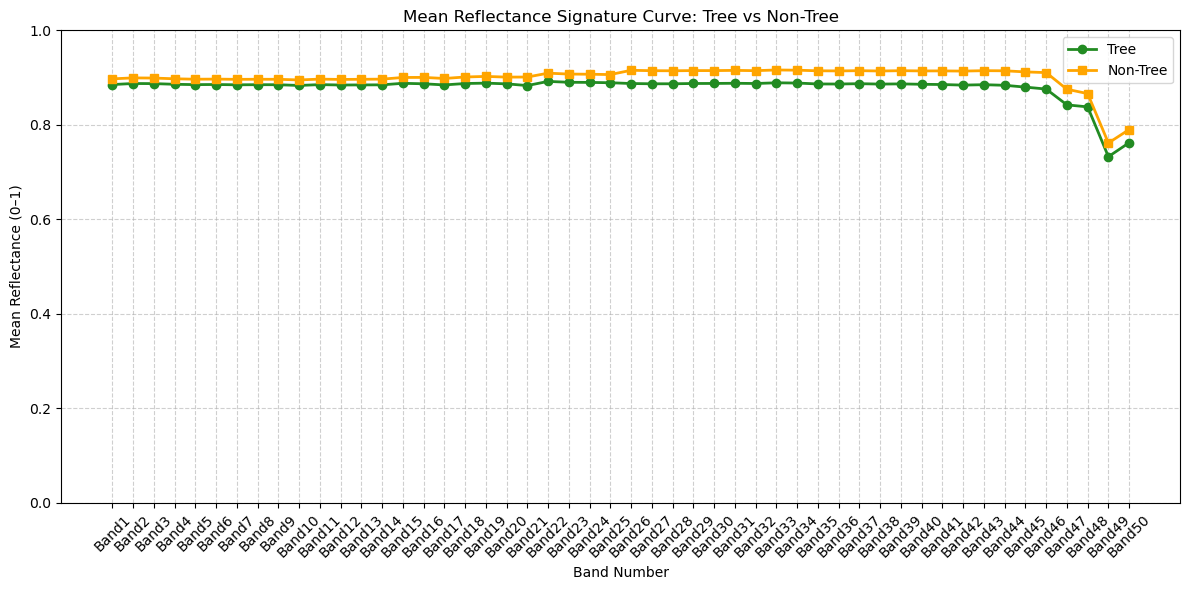

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os

tree_csv = r"E:\Hyperspectral\TreeExtraction\Data\Tree_Pixels_Reflectance.csv"
non_tree_csv = r"E:\Hyperspectral\TreeExtraction\Data\Non_Tree_Pixels_Reflectance.csv"
merged_csv = r"E:\Hyperspectral\TreeExtraction\Data\Merged_Pixels_Reflectance.csv"

df_tree = pd.read_csv(tree_csv)
df_non_tree = pd.read_csv(non_tree_csv)

df_merged = pd.concat([df_tree, df_non_tree], ignore_index=True)

df_merged.to_csv(merged_csv, index=False)
print(f"✅ Merged CSV saved to {merged_csv}")

band_columns = [col for col in df_merged.columns if col.startswith("Band")]

mean_tree = df_merged[df_merged["Class_Name"]=="Tree"][band_columns].mean()
mean_non_tree = df_merged[df_merged["Class_Name"]=="Non_Tree"][band_columns].mean()

plt.figure(figsize=(12, 6))
plt.plot(band_columns, mean_tree, marker='o', color='forestgreen', label='Tree', linewidth=2)
plt.plot(band_columns, mean_non_tree, marker='s', color='orange', label='Non-Tree', linewidth=2)

plt.xlabel("Band Number")
plt.ylabel("Mean Reflectance (0–1)")
plt.title("Mean Reflectance Signature Curve: Tree vs Non-Tree")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd
import rasterio
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

merged_csv = r"E:\Hyperspectral\TreeExtraction\Data\Merged_Pixels_Reflectance.csv"
mosaic_tif = r"E:\Hyperspectral\TreeExtraction\Data\MosaicTopBands\Mosaic_Top_Unique_Bands.tif"
output_dir = r"E:\Hyperspectral\TreeExtraction\Data\XGBoost_Output"
os.makedirs(output_dir, exist_ok=True)

xgb_model_path = os.path.join(output_dir, "XGBoost_TreeModel.pkl")
classified_raster = os.path.join(output_dir, "Mosaic_Top15Bands_Classified.tif")
cm_image_path = os.path.join(output_dir, "Confusion_Matrix.png")
report_txt_path = os.path.join(output_dir, "Classification_Report.txt")
bar_chart_path = os.path.join(output_dir, "Evaluation_Metrics_BarChart.png")
classified_map_img = os.path.join(output_dir, "Classified_Map.png")

df = pd.read_csv(merged_csv)
feature_cols = [col for col in df.columns if col.startswith("Band")]
X = df[feature_cols].values
y = df["Class"].values - 1  # 0=Tree, 1=Non-Tree

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42
)

param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'max_depth': [8, 10, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=200,
    scoring='accuracy',
    cv=50,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_clf = random_search.best_estimator_

print("✅ Best parameters:", random_search.best_params_)
print("✅ Best CV accuracy:", random_search.best_score_)

y_pred = best_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n\nClassification Report:\n{report}")

with open(report_txt_path, "w") as f:
    f.write(f"Accuracy: {acc:.4f}\n\n{report}")
print(f"✅ Classification report saved: {report_txt_path}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Tree","Non-Tree"], yticklabels=["Tree","Non-Tree"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(cm_image_path)
plt.close()
print(f"✅ Confusion matrix saved: {cm_image_path}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mbe = np.mean(y_pred - y_test)
mae = mean_absolute_error(y_test, y_pred)

metrics_names = ["Accuracy", "RMSE", "R²", "MBE", "MAE"]
metrics_values = [acc, rmse, r2, mbe, mae]

plt.figure(figsize=(8,6))
bars = plt.bar(metrics_names, metrics_values, color=['skyblue','orange','green','red','purple'])
plt.title("Evaluation Metrics")
plt.ylabel("Value")
plt.ylim(0, max(metrics_values)*1.2)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.savefig(bar_chart_path)
plt.close()
print(f"✅ Evaluation metrics bar chart saved: {bar_chart_path}")

# Save trained model
joblib.dump(best_clf, xgb_model_path)
print(f"✅ XGBoost model saved to {xgb_model_path}")

with rasterio.open(mosaic_tif) as src:
    full_data = src.read().astype(np.float32)
    profile = src.profile

bands, height, width = full_data.shape
X_full = full_data.reshape(bands, -1).T
X_full[np.isnan(X_full)] = 0

y_full_pred = best_clf.predict(X_full)
y_full_raster = (y_full_pred + 1).reshape(height, width)

def majority_filter(raster, size=7):
    pad = size // 2
    padded = np.pad(raster, pad, mode='edge')
    filtered = np.zeros_like(raster)
    for i in range(raster.shape[0]):
        for j in range(raster.shape[1]):
            window = padded[i:i+size, j:j+size]
            filtered[i,j] = stats.mode(window, axis=None, keepdims=True).mode.item()
    return filtered

y_full_raster_filtered = majority_filter(y_full_raster, size=7)

# Save classified raster
profile.update(count=1, dtype=rasterio.uint8, compress="lzw", nodata=0)
with rasterio.open(classified_raster, "w", **profile) as dst:
    dst.write(y_full_raster_filtered.astype(rasterio.uint8), 1)
print(f"✅ Classified map with majority filter saved: {classified_raster}")

plt.figure(figsize=(10,8))
plt.imshow(y_full_raster_filtered, cmap='tab20')0
plt.title("Tree vs Non-Tree Classified Map (Majority Filtered)")
plt.colorbar(label="Class (1=Tree, 2=Non-Tree)")
plt.axis('off')
plt.tight_layout()
plt.savefig(classified_map_img)
plt.close()
print(f"✅ Classified map image saved: {classified_map_img}")


Fitting 50 folds for each of 200 candidates, totalling 10000 fits
✅ Best parameters: {'subsample': 1.0, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
✅ Best CV accuracy: 0.9446666666666667
Accuracy: 0.9355

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        62
           1       0.91      0.97      0.94        62

    accuracy                           0.94       124
   macro avg       0.94      0.94      0.94       124
weighted avg       0.94      0.94      0.94       124

✅ Classification report saved: E:\Hyperspectral\TreeExtraction\Data\XGBoost_Output\Classification_Report.txt
✅ Confusion matrix saved: E:\Hyperspectral\TreeExtraction\Data\XGBoost_Output\Confusion_Matrix.png
✅ Evaluation metrics bar chart saved: E:\Hyperspectral\TreeExtraction\Data\XGBoost_Output\Evaluation_Metrics_BarChart.png
✅ XGBoost model saved to E:\Hyperspectral\TreeExtraction\Data\XGBoost_Out